# Extract Summit Local-Chapter India

```bash
curl -LsSf https://astral.sh/uv/install.sh | sh
uv venv --python 3.11
source .venv/bin/activate
uv pip install -r requirements.txt
```

Above commands:  
Installs `uv` -> Installs python (if not present) -> creates and activates venv -> installs requirements  
pip can be used for this too, uv is faster!

## import required libraries

In [1]:
import base64
import json
import random
import time
from math import ceil
from urllib.parse import parse_qs, urlparse

import pandas as pd
import requests
from bs4 import BeautifulSoup
from curl_cffi import requests as curl_cffi_requests
from IPython.display import Image, display
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.support.ui import WebDriverWait
from tqdm.auto import tqdm
from webdriver_manager.chrome import ChromeDriverManager

In [2]:
# code source: https://gist.github.com/MLKrisJohnson/2d2df47879ee6afd3be9d6788241fe99
# This code is based upon code at <https://mermaid.js.org/config/Tutorials.html#jupyter-integration-with-mermaid-js>.


def mm_ink(graphbytes):
    """Given a bytes object holding a Mermaid-format graph, return a URL that will generate the image."""
    base64_bytes = base64.b64encode(graphbytes)
    base64_string = base64_bytes.decode("ascii")
    return "https://mermaid.ink/img/" + base64_string


def mm_display(graphbytes):
    """Given a bytes object holding a Mermaid-format graph, display it."""
    display(Image(url=mm_ink(graphbytes)))


def mm(graph):
    """Given a string containing a Mermaid-format graph, display it."""
    graphbytes = graph.encode("ascii")
    mm_display(graphbytes)

- Let's explore web scraping by building something useful - a tool that tracks shoe prices across different websites
- On Nike's website, like most e-commerce platforms, products are organized in a hierarchy - similar to folders on your computer. At the most detailed level, we have individual products like "Air Jordan 1 High OG."
- These products are grouped into subcategories (like "Basketball Shoes" or "Running Shoes"), which are then organized under broader categories (like "Men's Shoes" or "Women's Shoes") - making it easier to navigate and scrape systematically.

## Extracting nike product details

In [3]:
product_url = (
    "https://www.nike.com/in/t/zoom-fly-6-road-running-shoes-943Pvv/HV4366-072"
)

In [4]:
headers = {
    "accept": "text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.7",
    "accept-language": "en-US,en;q=0.9",
    "priority": "u=0, i",
    "user-agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/132.0.0.0 Safari/537.36",
}

response = curl_cffi_requests.get(
    product_url,
    headers=headers,
)

In [5]:
response.status_code

200

In [6]:
mm(
    """
graph TD
    A[Web Page] --> B{Check Response Type}
    B -->|HTML| C[Use XPath/CSS Selectors]
    B -->|JSON| D[Use JPath/Python Dict]
    B -->|Mixed| E[HTML with Embedded JSON]
    E --> F[Extract JSON using BS4]
    F --> G[Parse Extracted JSON]
    
    C -->|Extract Data| H[Final Data]
    D -->|Extract Data| H
    G -->|Extract Data| H    
"""
)

In [7]:
def extract_next_data(html_content):
    # Parse the HTML
    soup = BeautifulSoup(html_content, "html.parser")

    # Find the script tag with id="__NEXT_DATA__"
    next_data_script = soup.find("script", id="__NEXT_DATA__")

    if next_data_script:
        # Extract and parse the JSON content
        json_data = json.loads(next_data_script.string)
        return json_data

    return None


data = extract_next_data(response.text)

In [8]:
def extract_nike_product_info(data):
    """
    Extract key information from Nike product JSON data.

    Args:
        data: dict containing Nike product data

    Returns:
        dict: Dictionary containing extracted product information
    """
    try:
        # Navigate to the product data
        product_data = data["props"]["pageProps"]["selectedProduct"]

        # Extract basic product information
        extracted_info = {
            "title": product_data["productInfo"]["title"],
            "subtitle": product_data["productInfo"]["subtitle"],
            "full_title": product_data["productInfo"]["fullTitle"],
            "description": product_data["productInfo"]["productDescription"],
            "color_description": product_data["colorDescription"],
            "style_code": product_data["styleCode"],
            "price": {
                "current": product_data["prices"]["currentPrice"],
                "currency": product_data["prices"]["currency"],
            },
            "country_origin": product_data["manufacturingCountriesOfOrigin"][0],
            "available_sizes": [],
        }

        # Extract available sizes
        for size in product_data["sizes"]:
            size_info = {
                "label": size["label"],
                "localized_label": size["localizedLabel"],
                "prefix": size["localizedLabelPrefix"],
                "status": size["status"],
            }
            extracted_info["available_sizes"].append(size_info)

        # Extract benefits
        benefits = []
        for feature in product_data["productInfo"]["featuresAndBenefits"]:
            if feature["header"] == "Benefits":
                benefits = feature["body"]
        extracted_info["benefits"] = benefits

        # Extract product details
        details = []
        for detail_section in product_data["productInfo"]["productDetails"]:
            if detail_section["header"] == "Product details":
                details = detail_section["body"]
        extracted_info["product_details"] = details

        return extracted_info

    except Exception as e:
        return f"Error extracting data: {str(e)}"


product_info = extract_nike_product_info(data)

In [9]:
with open("nike_product.json", "w") as f:
    json.dump(product_info, f, indent=4)

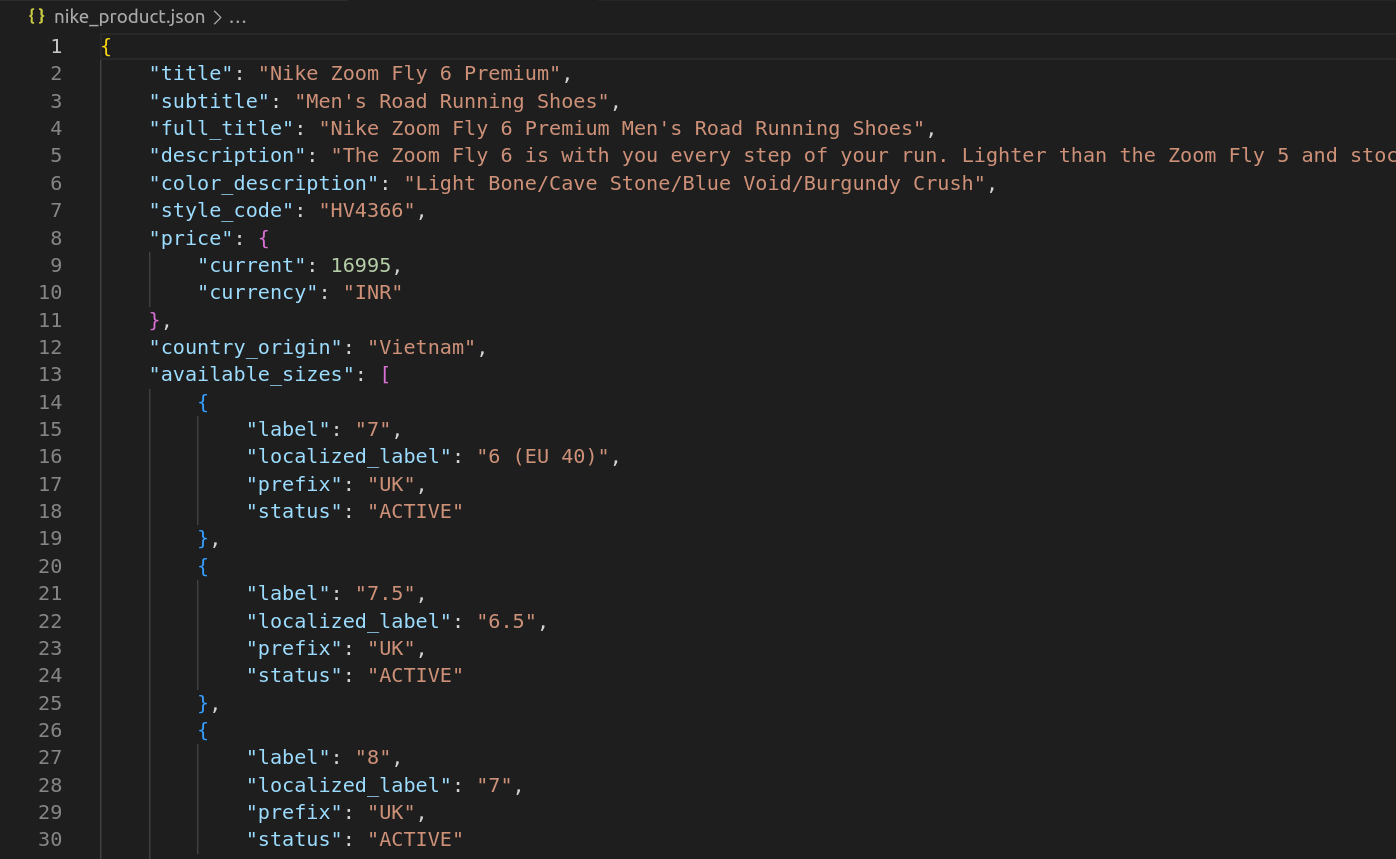

# Extracting nike subcategory and category details

* Most modern websites like Nike load their product data through APIs, but they hide API parameters (like concept_ids) in their HTML page for security. This two-step approach of first visiting the HTML page to extract these "secret keys" helps prevent unauthorized bulk scraping and API abuse.

* The advantage of this approach is that once we have these parameters, we can use the same APIs that Nike's frontend uses - giving us access to clean, structured JSON data instead of having to parse messy HTML. This means more reliable data extraction and easier access to paginated results through API parameters.

In [10]:
mm(
    """
flowchart TD
    A[Category URLs] -->|Request| B[HTML Page]
    B -->|Extract using BeautifulSoup| C[concept_ids]
    B -->|Extract| D[path]
    
    C -->|Build API URL| E[API URL Constructor]
    D -->|Build API URL| E
    
    E -->|Request| F[Product API]
    F -->|Parse JSON Response| G[Product Data]
    
    G -->|More Pages?| H{Check next_page}
    H -->|Yes| F
    H -->|No| I[Save to CSV]
"""
)

In [11]:
# Category URLs
URLS = [
    "https://www.nike.com/in/w/mens-shoes-nik1zy7ok",
    "https://www.nike.com/in/w/womens-shoes-5e1x6zy7ok",
    "https://www.nike.com/in/w/kids-shoes-v4dhzy7ok",
]

CONSUMER_CHANNEL_ID = "d9a5bc42-4b9c-4976-858a-f159cf99c647"


def get_headers(type="html"):
    """Return appropriate headers based on request type"""
    if type == "html":
        return {
            "accept": "text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8",
            "accept-language": "en-US,en;q=0.9",
            "user-agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/132.0.0.0 Safari/537.36",
        }
    else:  # API headers
        return {
            "accept": "*/*",
            "accept-language": "en-US,en;q=0.9",
            "nike-api-caller-id": "nike:dotcom:browse:wall.client:2.0",
            "origin": "https://www.nike.com",
            "referer": "https://www.nike.com/",
            "user-agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/132.0.0.0 Safari/537.36",
        }


def extract_concept_ids(session, url):
    """Extract concept IDs from Nike category page"""
    try:
        print(f"\nFetching HTML from: {url}")
        response = session.get(url, headers=get_headers("html"))
        soup = BeautifulSoup(response.text, "html.parser")

        meta_tag = soup.find("meta", {"name": "branch:deeplink:$deeplink_path"})
        if not meta_tag or not meta_tag.get("content"):
            print(f"No concept IDs found for {url}")
            return None

        deeplink_path = meta_tag["content"]
        query_params = parse_qs(urlparse(deeplink_path).query)

        if "conceptid" not in query_params:
            print(f"No concept IDs in meta tag for {url}")
            return None

        return query_params["conceptid"][0]

    except Exception as e:
        print(f"Error extracting concept IDs for {url}: {str(e)}")
        return None


def parse_response(response_json):
    """Parse API response and extract product information"""
    try:
        products_df = pd.json_normalize(
            [
                i.get("products")[0]
                for i in response_json["productGroupings"]
                if i.get("products")
            ]
        )[
            [
                "productCode",
                "badgeLabel",
                "copy.title",
                "copy.subTitle",
                "prices.currency",
                "prices.currentPrice",
                "pdpUrl.url",
                "colorwayImages.portraitURL",
            ]
        ]
        return [products_df]
    except Exception as e:
        print(f"Error parsing response: {str(e)}")
        return []


def fetch_nike_products(session, url, category):
    """Fetch all products for a given category URL"""
    try:
        headers = get_headers("api")
        print(f"\nFetching API data from: {url}")

        # Get initial response
        initial_response = session.get(url, headers=headers)
        data = initial_response.json()

        total_products = data["pages"]["totalResources"]
        count = 100  # Maximum allowed count

        # Calculate total pages properly
        total_pages = ceil(total_products / count) - 1

        # Initialize variables
        all_products = []
        next_page = data["pages"]["next"]

        # Parse and add initial products
        initial_products = parse_response(data)
        all_products.extend(initial_products)

        # Create progress bar for pagination
        with tqdm(
            total=total_pages,  # Use calculated total pages
            desc=f"Fetching {category}",
            leave=False,
            initial=1,  # Start from 1 since we've done initial request
        ) as pbar:
            while next_page:
                # Random sleep between 1-3 seconds
                time.sleep(random.uniform(1, 3))

                next_url = f"https://api.nike.com{next_page}"
                print(f"\nFetching next page: {next_url}")

                # Make request for next page
                response = session.get(next_url, headers=headers)
                data = response.json()

                # Parse and update products list
                new_products = parse_response(data)
                all_products.extend(new_products)

                # Get next page URL before updating progress
                next_page = data["pages"].get("next")

                # Update progress only if there's more to fetch
                if next_page:
                    pbar.update(1)

        # Combine all products and add category
        if all_products:
            df = pd.concat(all_products, ignore_index=True)
            df["category"] = category
            return df

    except Exception as e:
        print(f"Error fetching products for {category}: {str(e)}")

    return pd.DataFrame()


def construct_api_url(concept_ids, path):
    """Construct Nike API URL with concept IDs"""
    base_url = "https://api.nike.com/discover/product_wall/v1"
    params = {"marketplace": "IN", "language": "en-GB", "count": 100, "anchor": 0}

    url = (
        f"{base_url}/marketplace/{params['marketplace']}/language/{params['language']}"
    )
    url += f"/consumerChannelId/{CONSUMER_CHANNEL_ID}"
    url += f"?path={path}"
    url += f"&attributeIds={concept_ids}"
    url += f"&queryType=PRODUCTS&anchor={params['anchor']}&count={params['count']}"

    return url


def extract_path_from_url(url):
    """Extract the path component from Nike URL"""
    parsed = urlparse(url)
    return parsed.path.lstrip("/")

`if count>100:`

```json
{
  "error_id": "a834c280-65b8-4fb5-862c-a82fd9c7803b",
  "errors": [
    {
      "code": "INCORRECT_COUNT_VALUE",
      "message": "Value in field is not correct. Expected value is 24 or 50 or 100"
    }
  ]
}
```

In [12]:
all_data = []
session = curl_cffi_requests.Session()
# Create progress bar for categories
with tqdm(total=len(URLS), desc="Processing categories") as pbar:

    for url in URLS:
        category = " ".join(url.split("/")[-1].split("-")[:-1])
        # Get concept IDs
        concept_ids = extract_concept_ids(session, url)
        if not concept_ids:
            pbar.update(1)
            continue

        # Extract path from URL
        path = extract_path_from_url(url)

        # Construct API URL
        api_url = construct_api_url(concept_ids, path)

        # Fetch products
        df = fetch_nike_products(session, api_url, category)
        if not df.empty:
            all_data.append(df)

        pbar.update(1)

# Combine all data
if all_data:
    final_df = pd.concat(all_data, ignore_index=True)
    final_df.to_csv("nike_products.csv", index=False)
    print(f"\nTotal products saved: {len(final_df)}")
else:
    print("No data collected")

Processing categories:   0%|          | 0/3 [00:00<?, ?it/s]


Fetching HTML from: https://www.nike.com/in/w/mens-shoes-nik1zy7ok

Fetching API data from: https://api.nike.com/discover/product_wall/v1/marketplace/IN/language/en-GB/consumerChannelId/d9a5bc42-4b9c-4976-858a-f159cf99c647?path=in/w/mens-shoes-nik1zy7ok&attributeIds=16633190-45e5-4830-a068-232ac7aea82c,0f64ecc7-d624-4e91-b171-b83a03dd8550&queryType=PRODUCTS&anchor=0&count=100


Fetching mens shoes:  17%|#6        | 1/6 [00:00<?, ?it/s]


Fetching next page: https://api.nike.com/discover/product_wall/v1/marketplace/IN/language/en-GB/consumerChannelId/d9a5bc42-4b9c-4976-858a-f159cf99c647?path=in/w/mens-shoes-nik1zy7ok&attributeIds=16633190-45e5-4830-a068-232ac7aea82c,0f64ecc7-d624-4e91-b171-b83a03dd8550&queryType=PRODUCTS&anchor=100&count=100

Fetching next page: https://api.nike.com/discover/product_wall/v1/marketplace/IN/language/en-GB/consumerChannelId/d9a5bc42-4b9c-4976-858a-f159cf99c647?path=in/w/mens-shoes-nik1zy7ok&attributeIds=16633190-45e5-4830-a068-232ac7aea82c,0f64ecc7-d624-4e91-b171-b83a03dd8550&queryType=PRODUCTS&anchor=200&count=100

Fetching next page: https://api.nike.com/discover/product_wall/v1/marketplace/IN/language/en-GB/consumerChannelId/d9a5bc42-4b9c-4976-858a-f159cf99c647?path=in/w/mens-shoes-nik1zy7ok&attributeIds=16633190-45e5-4830-a068-232ac7aea82c,0f64ecc7-d624-4e91-b171-b83a03dd8550&queryType=PRODUCTS&anchor=300&count=100

Fetching next page: https://api.nike.com/discover/product_wall/v1/mar

Fetching womens shoes:  20%|##        | 1/5 [00:00<?, ?it/s]


Fetching next page: https://api.nike.com/discover/product_wall/v1/marketplace/IN/language/en-GB/consumerChannelId/d9a5bc42-4b9c-4976-858a-f159cf99c647?path=in/w/womens-shoes-5e1x6zy7ok&attributeIds=16633190-45e5-4830-a068-232ac7aea82c,7baf216c-acc6-4452-9e07-39c2ca77ba32&queryType=PRODUCTS&anchor=100&count=100

Fetching next page: https://api.nike.com/discover/product_wall/v1/marketplace/IN/language/en-GB/consumerChannelId/d9a5bc42-4b9c-4976-858a-f159cf99c647?path=in/w/womens-shoes-5e1x6zy7ok&attributeIds=16633190-45e5-4830-a068-232ac7aea82c,7baf216c-acc6-4452-9e07-39c2ca77ba32&queryType=PRODUCTS&anchor=200&count=100

Fetching next page: https://api.nike.com/discover/product_wall/v1/marketplace/IN/language/en-GB/consumerChannelId/d9a5bc42-4b9c-4976-858a-f159cf99c647?path=in/w/womens-shoes-5e1x6zy7ok&attributeIds=16633190-45e5-4830-a068-232ac7aea82c,7baf216c-acc6-4452-9e07-39c2ca77ba32&queryType=PRODUCTS&anchor=300&count=100

Fetching next page: https://api.nike.com/discover/product_wa

Fetching kids shoes:  20%|##        | 1/5 [00:00<?, ?it/s]


Fetching next page: https://api.nike.com/discover/product_wall/v1/marketplace/IN/language/en-GB/consumerChannelId/d9a5bc42-4b9c-4976-858a-f159cf99c647?path=in/w/kids-shoes-v4dhzy7ok&attributeIds=16633190-45e5-4830-a068-232ac7aea82c,145ce13c-5740-49bd-b2fd-0f67214765b3&queryType=PRODUCTS&anchor=100&count=100

Fetching next page: https://api.nike.com/discover/product_wall/v1/marketplace/IN/language/en-GB/consumerChannelId/d9a5bc42-4b9c-4976-858a-f159cf99c647?path=in/w/kids-shoes-v4dhzy7ok&attributeIds=16633190-45e5-4830-a068-232ac7aea82c,145ce13c-5740-49bd-b2fd-0f67214765b3&queryType=PRODUCTS&anchor=200&count=100

Fetching next page: https://api.nike.com/discover/product_wall/v1/marketplace/IN/language/en-GB/consumerChannelId/d9a5bc42-4b9c-4976-858a-f159cf99c647?path=in/w/kids-shoes-v4dhzy7ok&attributeIds=16633190-45e5-4830-a068-232ac7aea82c,145ce13c-5740-49bd-b2fd-0f67214765b3&queryType=PRODUCTS&anchor=300&count=100

Fetching next page: https://api.nike.com/discover/product_wall/v1/mar

#### the above code to extract nike categories data has been exported to `extract_nike_data.py`, and these changes are done:
1. categories changed from 3 to 9, and to make this process faster ThreadPoolExecutor is used for parallel requests
2. data is saved in 2 tables inside a sqlite database (instead of a csv file)

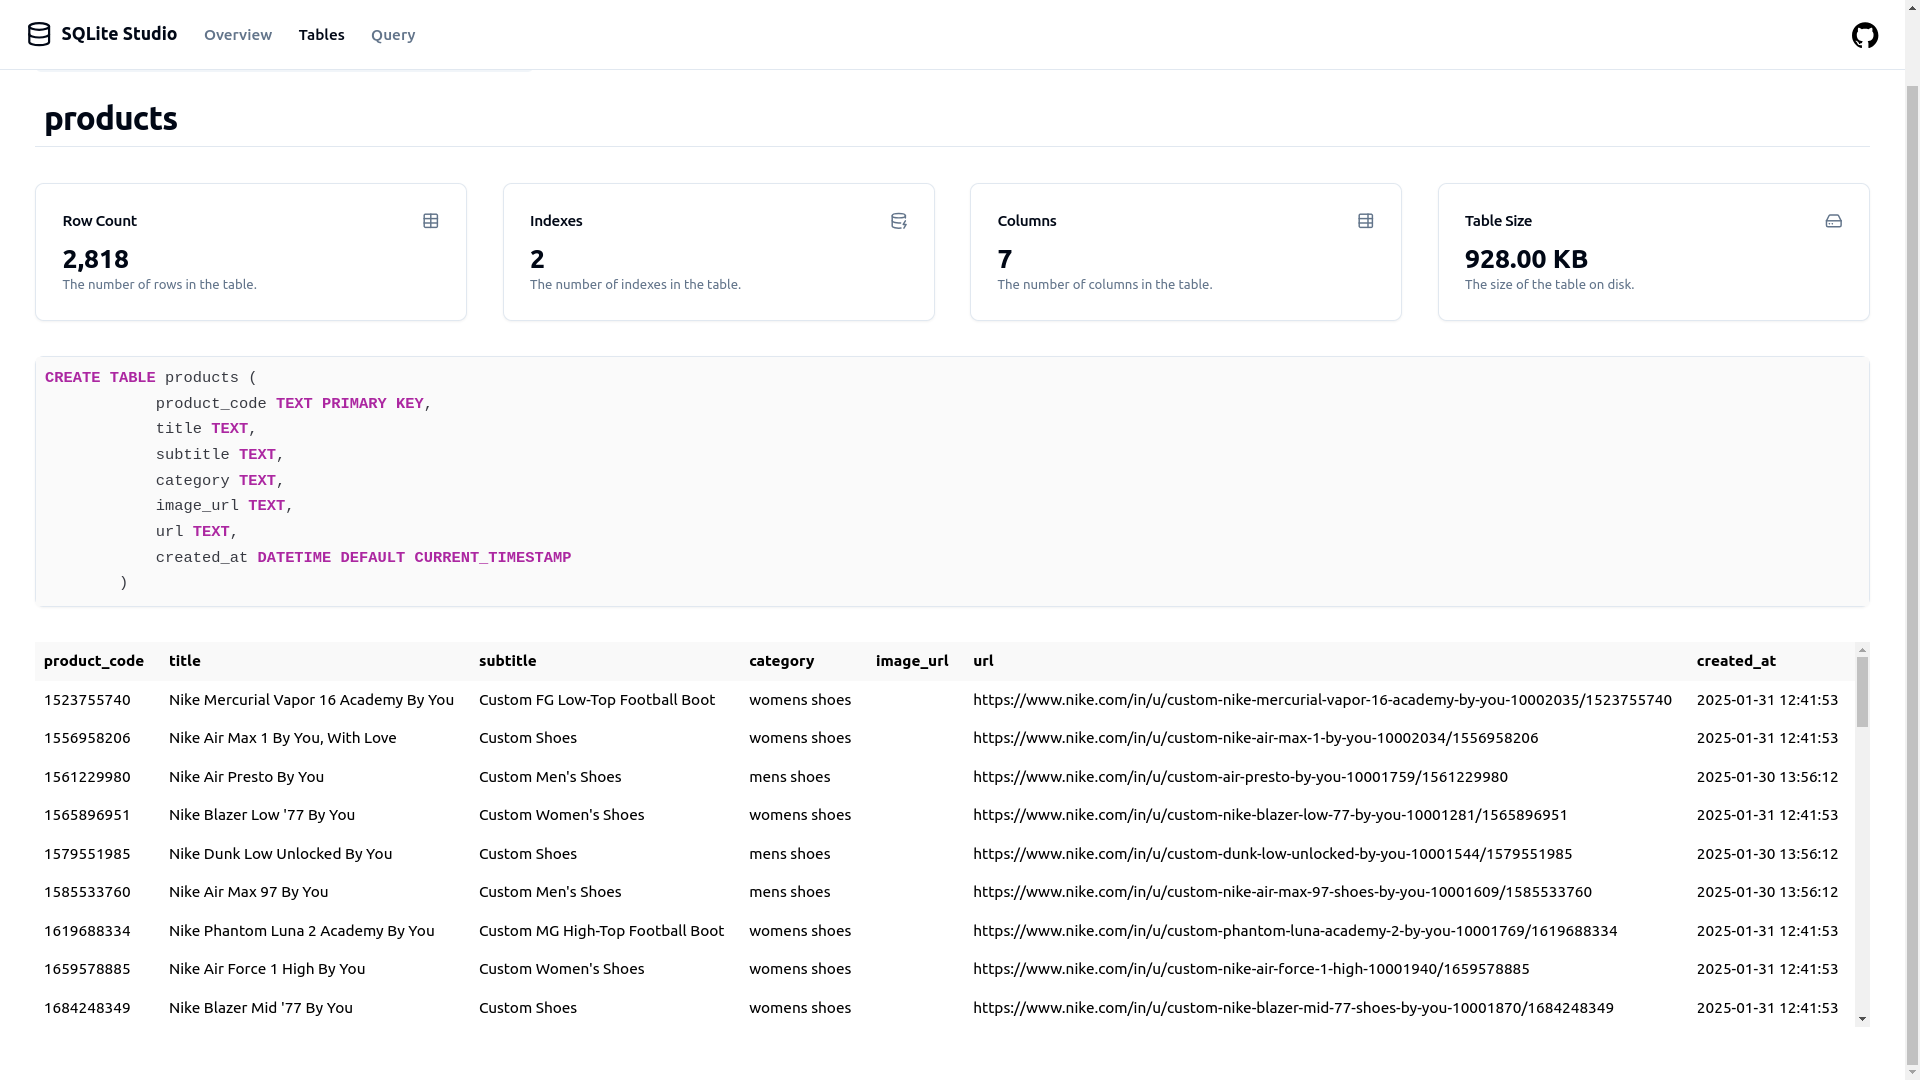

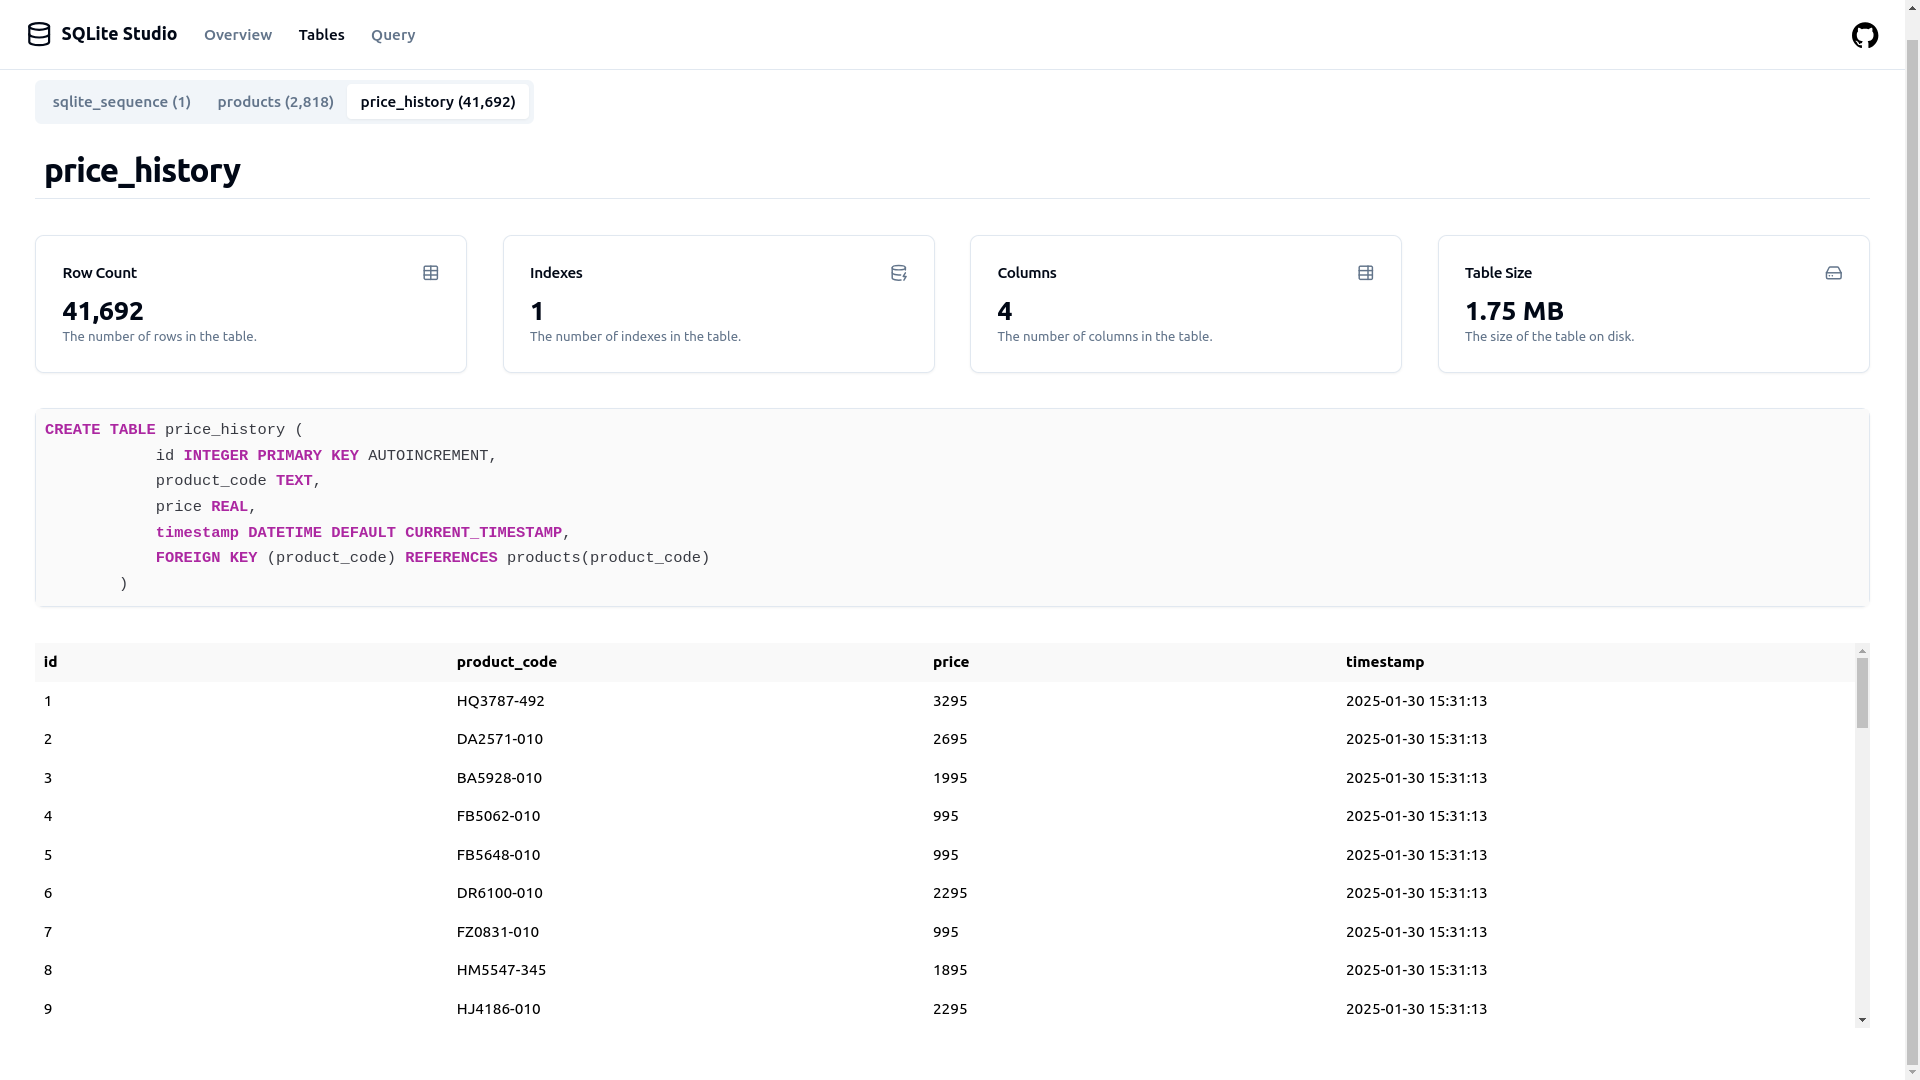

#### then a streamlit app is created to read data from the db and render it: `price_tracker.py`

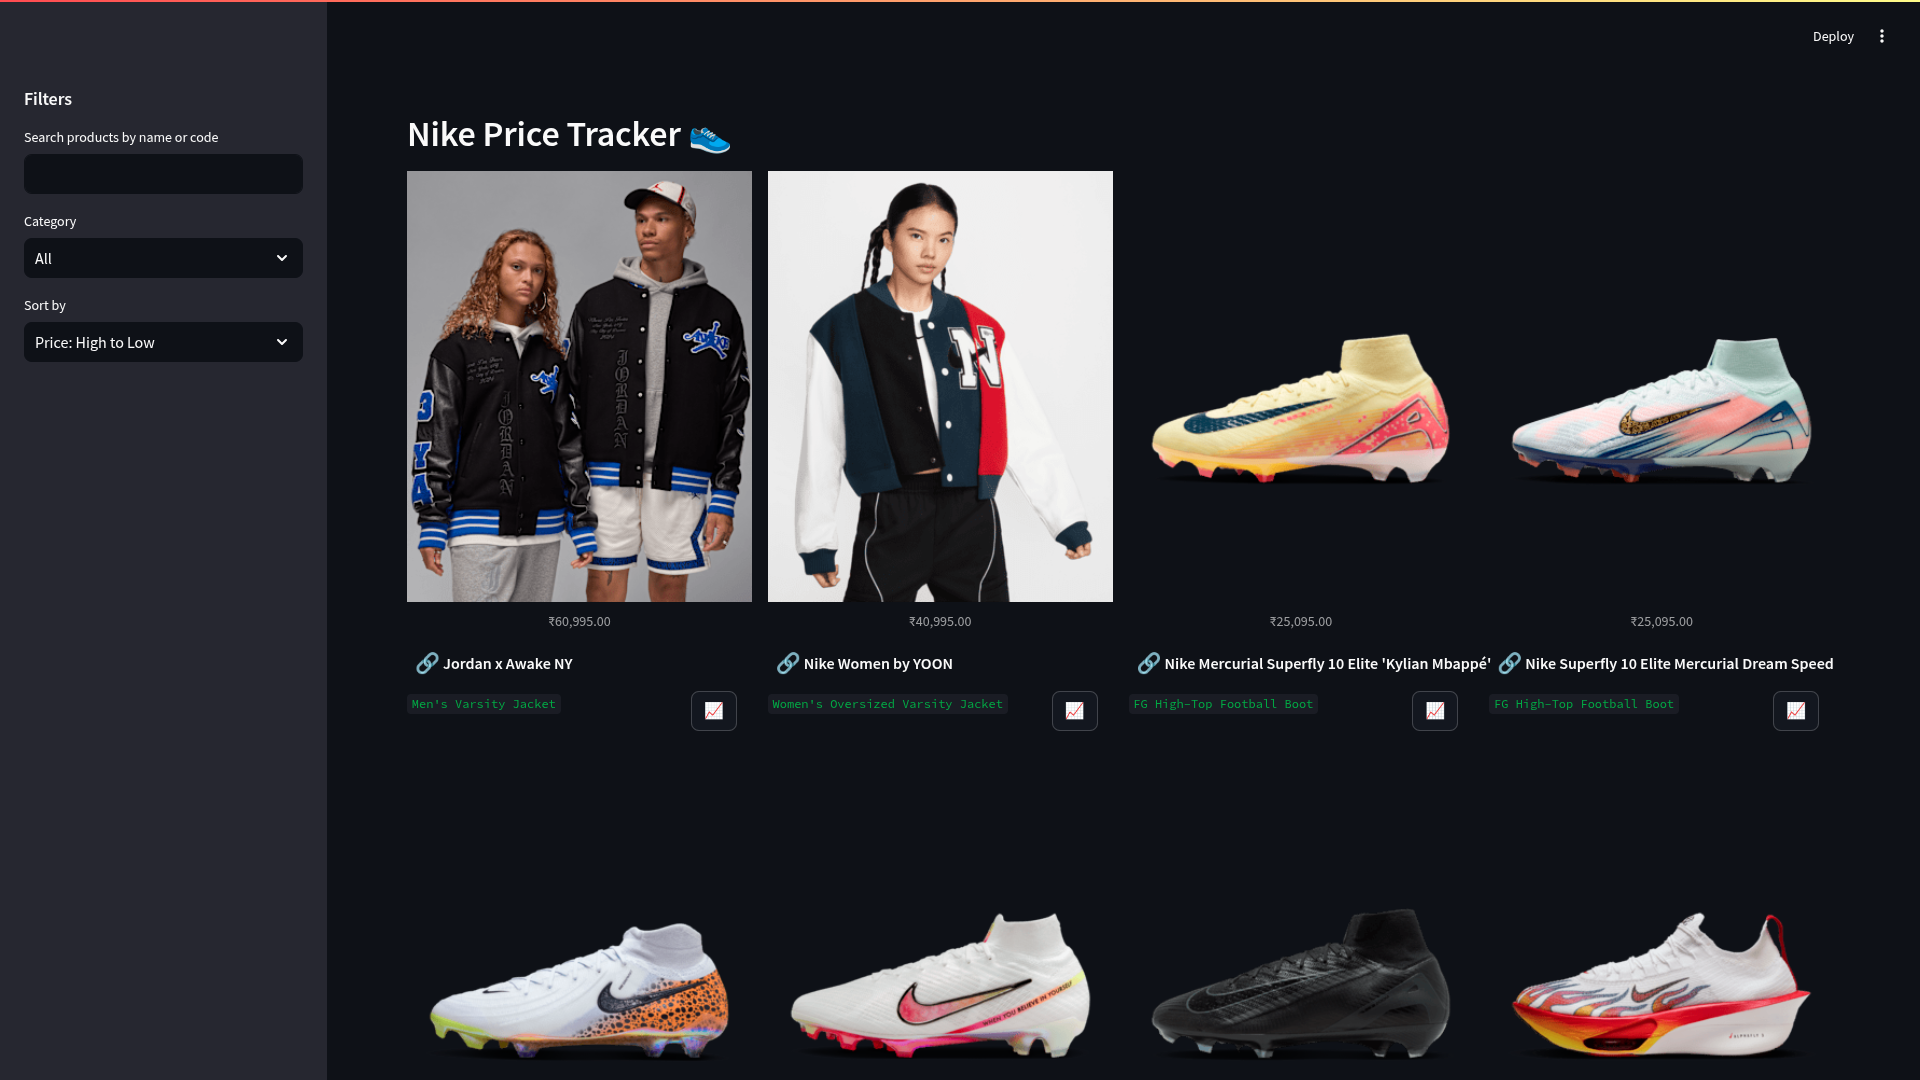

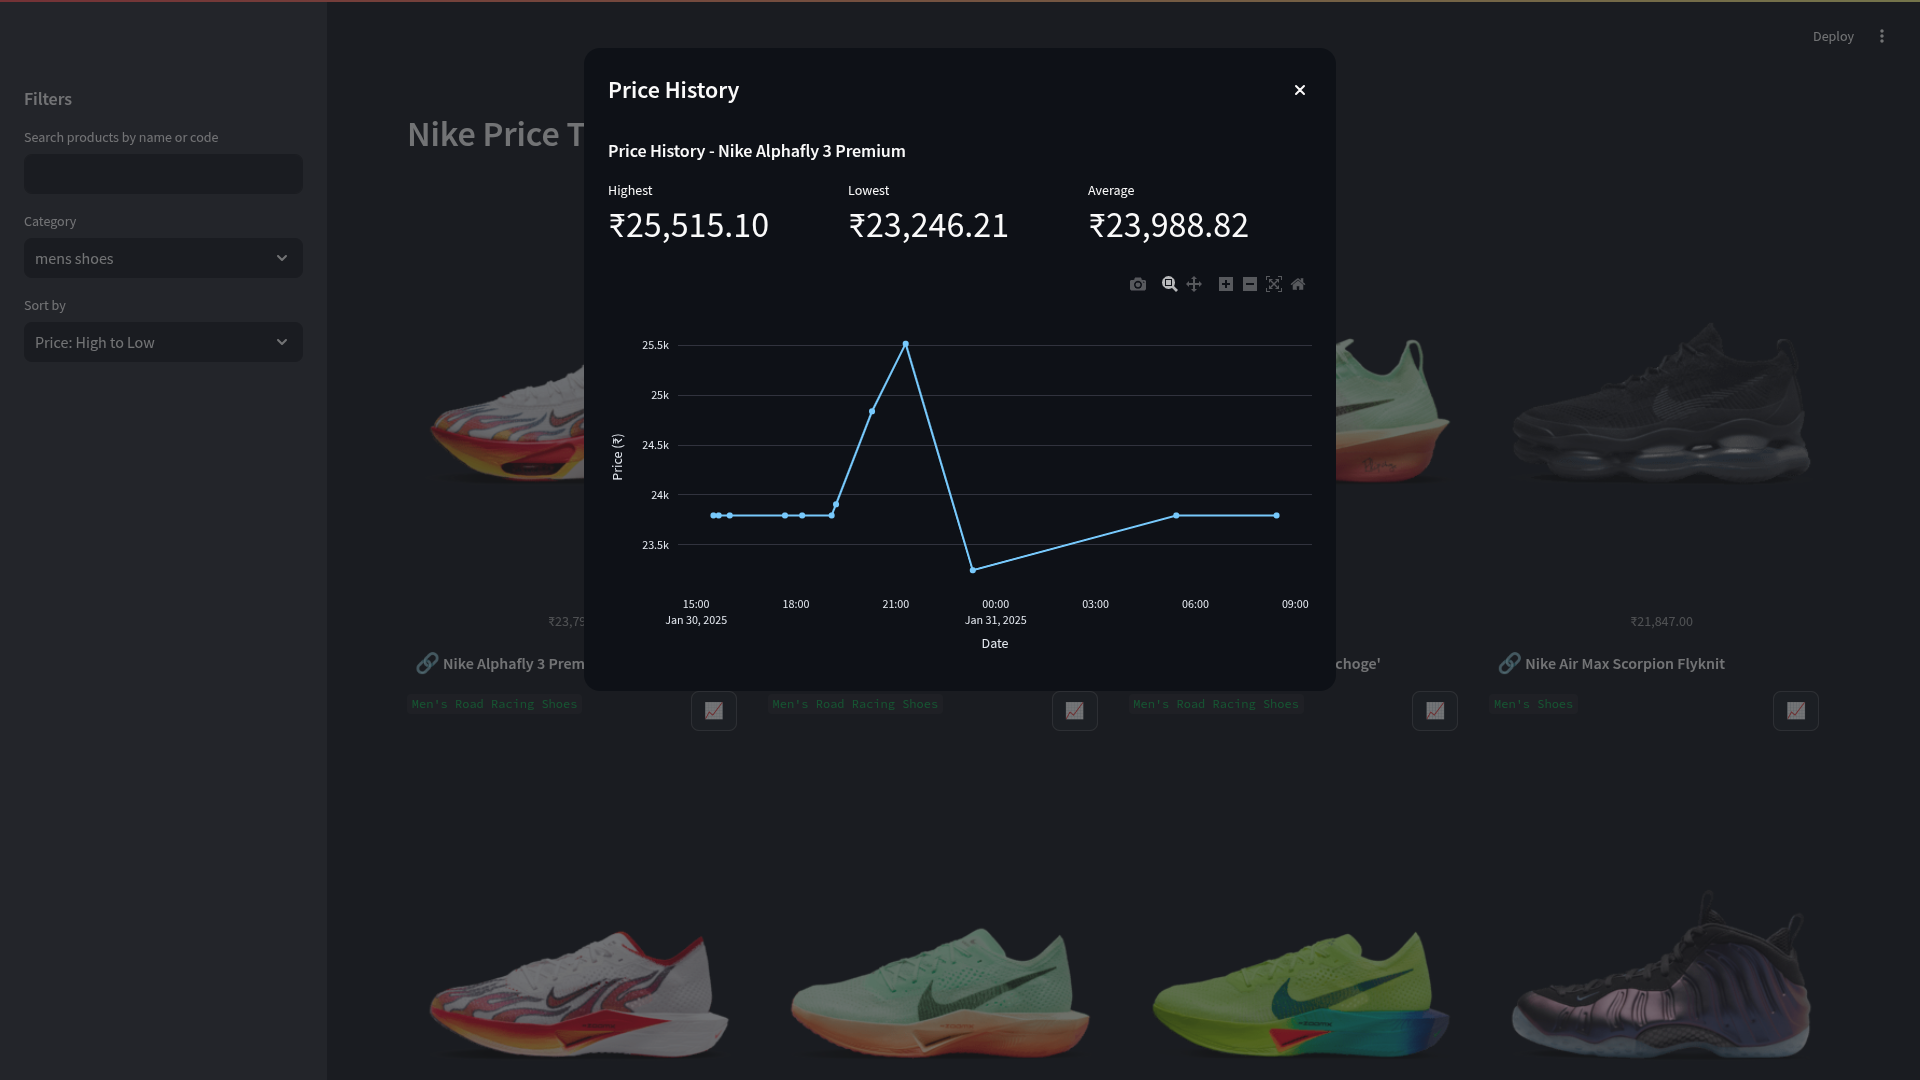

price history for all products is displayed
- typically `extract_nike_data.py` would be scheduled to run (ex: using cron) to collect data over time
- for this demo, a random noise was added to price, for a few crawls, such that price trend can be seen in the graph

# TLS fingerprinting

In [13]:
headers = {
    "accept": "text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.7",
    "accept-language": "en-US,en;q=0.9",
    "user-agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/132.0.0.0 Safari/537.36",
}

response = requests.get(
    "https://www.nike.com/in/launch/t/air-more-uptempo-low-white-and-hyper-royal",
    headers=headers,
)

with open("nike1.html", "w") as f:
    f.write(response.text)

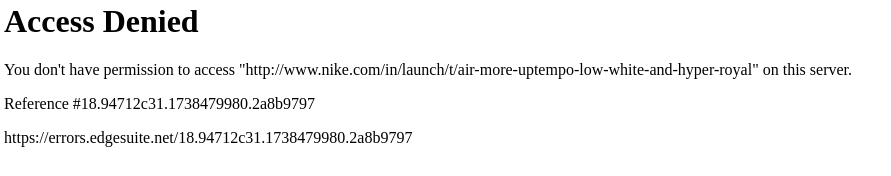

In [14]:
response = curl_cffi_requests.get(
    "https://www.nike.com/in/launch/t/air-more-uptempo-low-white-and-hyper-royal",
    headers=headers,
)
with open("nike2.html", "w") as f:
    f.write(response.text)

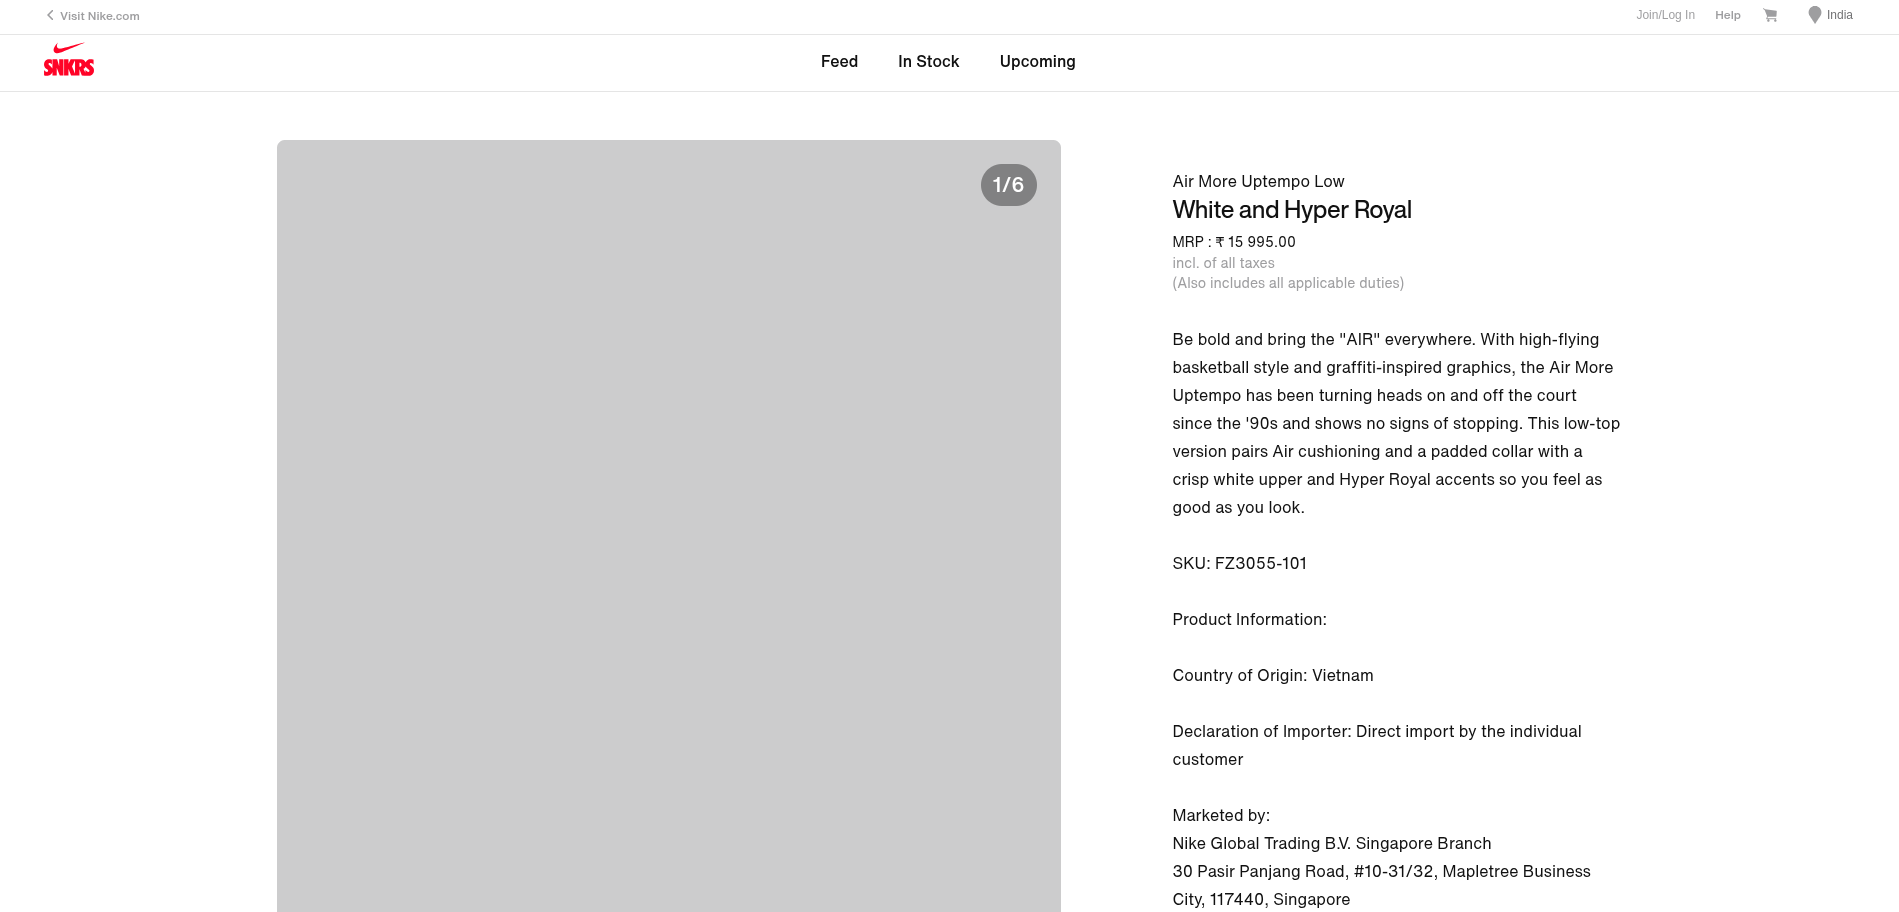

In [15]:
response = requests.get("https://tls.browserleaks.com/", headers=headers)
with open("requests.json", "w") as f:
    json.dump(response.json(), f, indent=4)

response = curl_cffi_requests.get("https://tls.browserleaks.com/", headers=headers)
with open("curl_cffi_requests.json", "w") as f:
    json.dump(response.json(), f, indent=4)

- TLS fingerprinting is a security measure where websites identify browsers by their unique combination of TLS features (cipher suites, extensions, and settings) - similar to how each person has a unique fingerprint. Your browser automatically sends this during the HTTPS handshake.
- curl-cffi doesn't match browser's TLS fingerprint exactly, but it provides a consistent, browser-like TLS implementation that includes critical features like proper cipher suites and HTTP/2 support. This makes it harder for websites to distinguish it from a real browser, unlike the requests library which has a very distinct fingerprint.

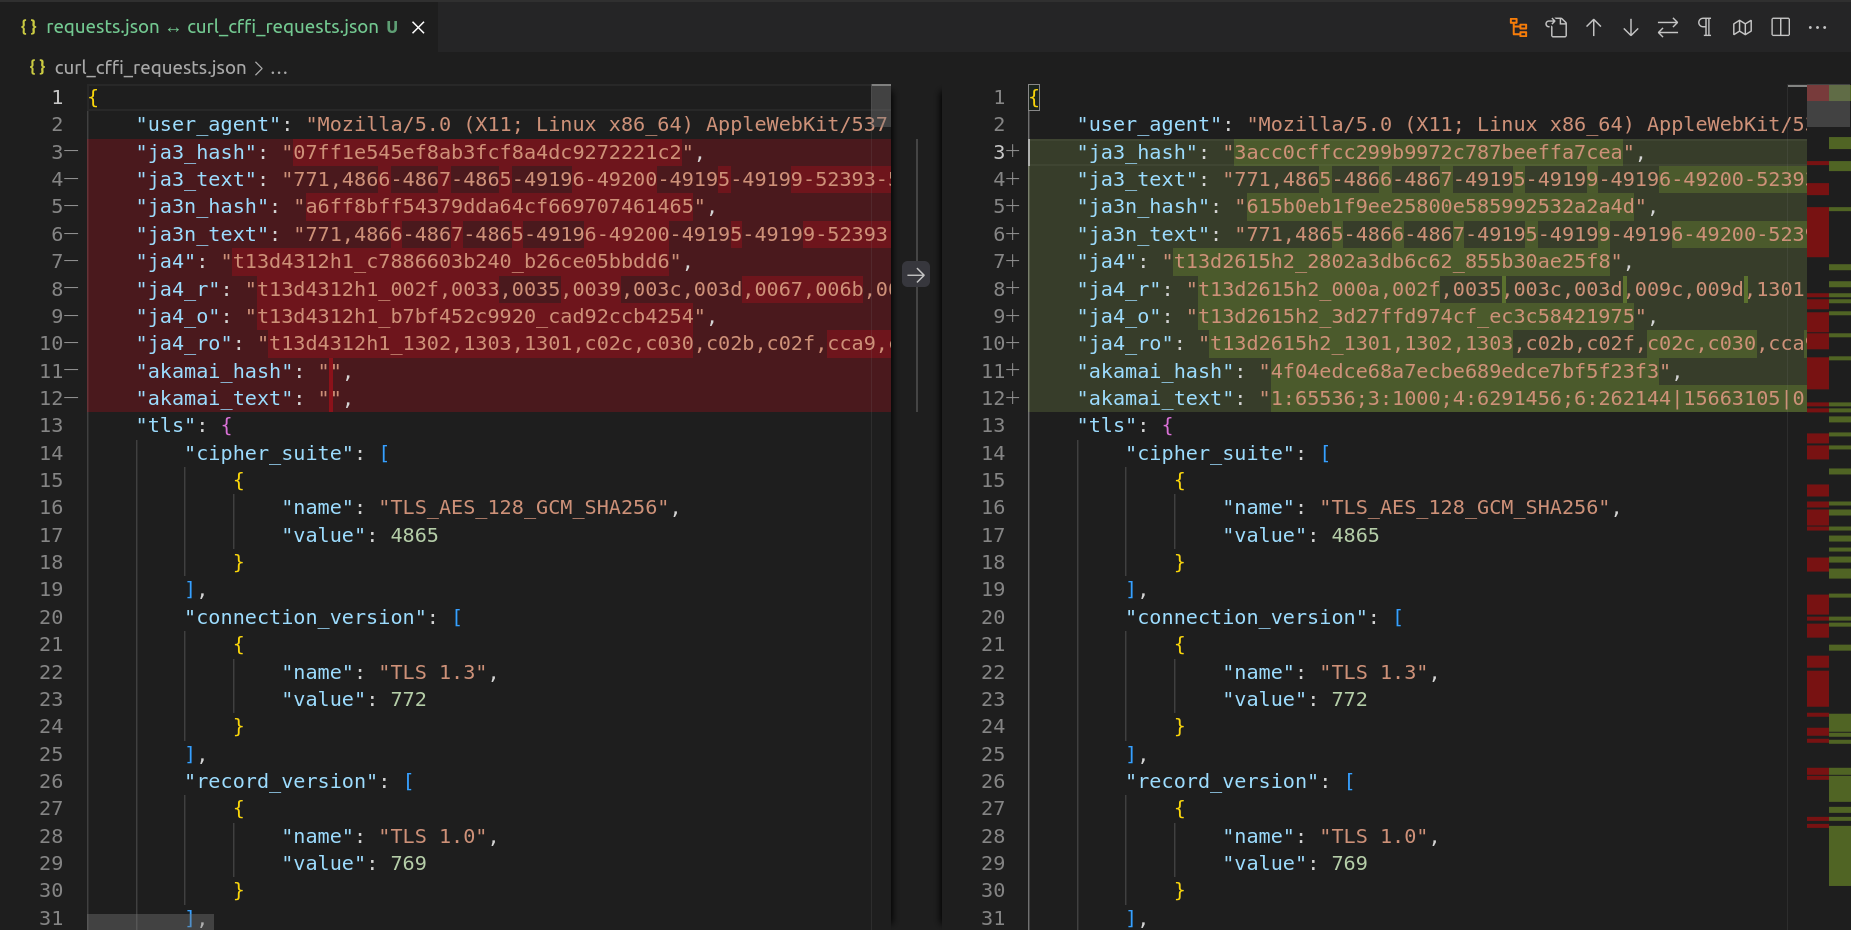

https://curl-cffi.readthedocs.io/en/latest/faq.html#faq

In [16]:
mm(
    """
flowchart LR
    A[Browser Request] --> B[TLS Fingerprint]
    B --> C{Matches?}
    
    D[requests Library] --> E[Different JA3 Hash]
    E --> C
    
    F[curl-cffi] --> G[Matching JA3 Hash]
    G --> C
    
    C -->|No| H[Website Blocks]
    C -->|Yes| I[Website Allows]
"""
)

# amazon: pincode + scroll (via selenium)

In [17]:
mm(
    """
flowchart LR
    A[Try Requests Library] --> B[Blocked by Captcha]
    B --> C[Try curl-cffi]
    C --> D[Basic Scraping Works]
    D --> E[Need Pincode Setting]
    E --> F{Choose Approach}
    F --> G[Replicate All Session Requests]
    F --> H[Use Selenium/Browser]
    
    G -.->|Complex but Faster| I[Handle Multiple Requests]
    H -.->|Simpler but Slower| J[Let Browser Handle Sessions]
"""
)

In [18]:
def setup_driver():
    print("Setting up the Chrome driver...")
    service = Service(ChromeDriverManager().install())
    driver = webdriver.Chrome(service=service)
    time.sleep(2)
    return driver


def update_location(driver, pincode):
    print("\nNavigating to Amazon.in...")
    driver.get("https://www.amazon.in")
    time.sleep(3)

    print("Clicking on location button...")
    location_button = WebDriverWait(driver, 10).until(
        EC.element_to_be_clickable((By.ID, "nav-global-location-popover-link"))
    )
    location_button.click()
    time.sleep(2)

    print(f"Entering pincode: {pincode}")
    pincode_input = WebDriverWait(driver, 10).until(
        EC.presence_of_element_located((By.ID, "GLUXZipUpdateInput"))
    )
    pincode_input.clear()
    time.sleep(1)
    pincode_input.send_keys(pincode)
    time.sleep(2)

    print("Applying pincode...")
    apply_button = WebDriverWait(driver, 10).until(
        EC.element_to_be_clickable((By.XPATH, '//*[@id="GLUXZipUpdate"]/span/input'))
    )
    apply_button.click()
    time.sleep(3)


def extract_product_data(driver, product_url):
    print(f"\nNavigating to product page: {product_url}")
    driver.get(product_url)
    time.sleep(4)

    print("Scrolling to bottom of page...")
    total_height = int(driver.execute_script("return document.body.scrollHeight"))
    for height in range(0, total_height, 100):
        driver.execute_script(f"window.scrollTo(0, {height})")
        time.sleep(0.1)

    # Extract data using provided selectors
    try:
        title = (
            WebDriverWait(driver, 10)
            .until(EC.presence_of_element_located((By.ID, "productTitle")))
            .text.strip()
        )

        price = (
            WebDriverWait(driver, 10)
            .until(
                EC.presence_of_element_located((By.CSS_SELECTOR, "span.a-price-whole"))
            )
            .text.strip()
        )

        image_url = (
            WebDriverWait(driver, 10)
            .until(
                EC.presence_of_element_located((By.CSS_SELECTOR, "img#landingImage"))
            )
            .get_attribute("src")
        )

        return {
            "Title": title,
            "Price": int(price.replace(",", "")),  # Convert price to integer
            "Image URL": image_url,
        }
    except Exception as e:
        print(f"Error extracting data: {str(e)}")
        return None


def main():
    driver = None
    try:
        driver = setup_driver()
        update_location(driver, "560001")

        # List of product URLs to scrape
        product_urls = [
            "https://www.amazon.in/Jordan-Loyal-Shoes-White-RED-Black/dp/B0D6Z1Z4FG",
            "https://www.amazon.in/Nike-Mens-Revolution-Black-Running/dp/B0C8TH2TXS",
            "https://www.amazon.in/NIKE-Revolution-Mens-Running-Shoes/dp/B0D7MHTTJM",
        ]

        # Collect data for all products
        products_data = []
        for url in product_urls:
            data = extract_product_data(driver, url)
            if data:
                products_data.append(data)

        # Create DataFrame
        df = pd.DataFrame(products_data)

        # Display table
        print("\nProduct Details:")
        display(df)

        # Display images
        print("\nProduct Images:")
        for idx, row in df.iterrows():
            print(f"\n{row['Title']}:")
            display(Image(url=row["Image URL"], width=200))

        print("\nScript completed successfully!")
        time.sleep(2)

    except Exception as e:
        print(f"\nAn error occurred: {str(e)}")
    finally:
        if driver:
            print("\nClosing browser...")
            driver.quit()


if __name__ == "__main__":
    main()

Setting up the Chrome driver...

Navigating to Amazon.in...
Clicking on location button...
Entering pincode: 560001
Applying pincode...

Navigating to product page: https://www.amazon.in/Jordan-Loyal-Shoes-White-RED-Black/dp/B0D6Z1Z4FG
Scrolling to bottom of page...

Navigating to product page: https://www.amazon.in/Nike-Mens-Revolution-Black-Running/dp/B0C8TH2TXS
Scrolling to bottom of page...

Navigating to product page: https://www.amazon.in/NIKE-Revolution-Mens-Running-Shoes/dp/B0D7MHTTJM
Scrolling to bottom of page...

Product Details:


,Title,Price,Image URL
0,NIKE Mens Jordan Stay Loyal 3 Running Shoes,9163,https://m.media-amazon.com/images/I/71slxw7HqT...
1,Nike Mens Revolution 7Running Shoe,2993,https://m.media-amazon.com/images/I/71lVk-4gvV...
2,NIKE Revolution 7 Men's Road Running Shoes (7),3436,https://m.media-amazon.com/images/I/81Qw4CuPc8...



Product Images:

NIKE Mens Jordan Stay Loyal 3 Running Shoes:



Nike Mens Revolution 7Running Shoe:



NIKE Revolution 7 Men's Road Running Shoes (7):



Script completed successfully!

Closing browser...


# A Step by Step Approach to Web Scraping 🕷️

### Part 1: Initial Setup & Request Strategy

![](https://mermaid.ink/img/pako:eNp9VEtz4jgQ_itdOuxlQhIMIR4fdotHMpBkslTM1D5EDsJusGpsySPJPAby37dtIOtA1fhA0d1fv7_WlkU6RhaweapXUSKMg8lgqoA-W8wWRuQJjJR0UqR36zzVRjipFZ-ygxJq2il73XuWX5eHjqK9QqPxO_S2_QSj72D0TDt76dYOfoMJmsy-_e_Rq6D9bSgdZiK_eglD6C6FTMUsxT9qwH4J3P2DdgcD_s0ihM4UkSsMxjAQTkCoCxOhfT11edY7uONfhSqo8L4Rq1SqBbzgj0KSbw1-V5Vyf6h6LBYIT1rEhK6VcV_FHKm5pFFQEZHRabqDL_zv4Qt0lUg3VtrT6KjiqTqZbwlB66gL4XCxoeEeNHBUQYgpRmczHm67yslGTzsYG-32iPqkhlWJPWFldPWsFe5gxEOZ5SnCcDIZHzPXJzWqWh81uTnYrhLn8jV8gkliUMRjrYkJGBVOG1I6VCKSbnMeweM2ovbqltPCJk8h3NNQ0eRGUidqsYMHXmp7m1xYCxNKVi_uoQr90ORRYdJGNJ_Lc-Mxb4P6RGO1ogn-ooYHsRS0Opm791Xt4JH3jF5ZNNClPrOK3bUYj1WmxyYv16JkkZ3bPD5OxWZl5CJx59YWtwfPxooyBiDnICKirAWnoVAxmnRTcvO4BCAmmXOeHsK1eelS7h_jRpQYnWFs5BJNUIbDpYgRZoeGZsLSmYiSN3SLv2BleUn7QzpymYhZO693in-g5BPvV_lhgMvT7X3lf4k8J6efVMcBdrcmBtmP432qunrm3fGI3h6b73ldAzxXgD_3NIi0ok4dmnOAVwG8DzystVodMAz3wpe6MNgL7IJl9EgJGdMDuS1NU-YSzHDKAvobC_N9yqbqjXCCeBJuVMQCeovwghldLBIWzEVqSSrymFg4kIJGm71rc6H-1To7upDIgi1bs8Dz25d-p3Pz2ff9VvP69qZ9wTYs-Oxf3t62Otc3XtvrNNu-93bBflYBmpdNr9nutHz6bV_7frv19h-aAM_A)

### Part 2: Execution & Maintenance

In [19]:
mm(
    """
flowchart TD
    subgraph DataExtraction["Data Extraction"]
        A{Data Format?}
        A -->|HTML| B[HTML Parsing Tools]
        B --> B1[BeautifulSoup]
        B --> B2[Selectolax]
        
        A -->|JSON| C[JSON Tools]
        C --> C1[JPath]
    end

    subgraph SessionManagement["Session Management"]
        D[requests.Session for Connection Reuse]
        E[Captcha Service Integration]
    end

    subgraph ScalingPerformance["Scaling & Performance"]
        F[Proxy Rotation]
        G[Distributed Scraping - scrapyd, selenium-grid]
        H[Queue Management]
    end

    subgraph StorageProcessing["Storage & Processing"]
        I[Data Format Handling]
        I --> I1[CSV]
        I --> I2[JSON]
        I --> I3[Database]
        J[Error Handling & Retries]
    end

    subgraph Monitoring["Monitoring - spidermon"]
        K[Site Change Detection]
        L[Performance Tracking]
        M[Log Management]
    end

    A --> D
    D --> F
    F --> I
    I --> K
"""
)

| Tool/Resource | Category | Link |
|--------------|----------|------|
| Requests | HTTP Library | https://github.com/psf/requests |
| HTTPX | HTTP Library | https://github.com/encode/httpx |
| Tenacity | Rate Limiting | https://github.com/jd/tenacity |
| Scrapy | Web Scraping Framework | https://github.com/scrapy/scrapy |
| curl-cffi | TLS Fingerprint Bypass | https://github.com/lexiforest/curl_cffi |
| scrapy-impersonate | TLS Fingerprint Bypass | https://github.com/jxlil/scrapy-impersonate |
| Selenium | Browser Automation | https://github.com/SeleniumHQ/Selenium |
| Playwright | Browser Automation | https://github.com/microsoft/playwright-python |
| selenium-wire | Request Interception | https://github.com/wkeeling/selenium-wire |
| curlconverter | Code Generation | https://curlconverter.com/ |
| curl2scrapy | Code Generation | https://michael-shub.github.io/curl2scrapy/ |
| BeautifulSoup | HTML Parsing | https://www.crummy.com/software/BeautifulSoup/bs4/doc/ |
| Selectolax | HTML Parsing | https://github.com/rushter/selectolax |
| XPath Practice | Learning Resource | https://topswagcode.dev/xpath/ |
| CSS Practice | Learning Resource | https://flukeout.github.io/ |
| JPath | JSON Parsing | https://thearmagan.github.io/JPATH/ |
| Wappalyzer | Technology Detection | https://www.wappalyzer.com/ |

